# Mapping GOES-16 Data with `Basemap` and `pyproj`
__Brian Blaylock__  
__September 18, 2017__

This notebook shows how to plot GOES-16 data on a Python Basemap and includes a method to reproject the data on a new map, specifically on the HRRR map projection and domain by getting the latitude and longitude of every pixel in the GOES image.

The methods here are stitched together from the following useful information I found online:
- [Open Commons Consortium](http://edc.occ-data.org/goes16/python/)
- [GeoNetCast Blog](https://geonetcast.wordpress.com/2017/07/25/geonetclass-manipulating-goes-16-data-with-python-part-vi/)
- [Proj documentation](http://proj4.org/projections/geos.html)
- [Pyproj documentation](http://jswhit.github.io/pyproj/pyproj.Proj-class.html)


## Download GOES-16 Data
For this demo, you'll need a GOES-16 data file. I created a [web interface](http://home.chpc.utah.edu/~u0553130/Brian_Blaylock/cgi-bin/goes16_download.cgi) to easily view and download files from [NOAA's Amazon S3 GOES Archive](https://aws.amazon.com/public-datasets/goes/).

Get a data file in multiband format for the continental United States (CONUS) from my webpage:  

http://home.chpc.utah.edu/~u0553130/Brian_Blaylock/cgi-bin/goes16_download.cgi?domain=C&product=ABI-L2-MCMIP&hour=0

Below, I use a __CONUS__ file in the __multiband format__. This file contains all 16 bands with the same 2 km resolution over the contiguous United States. Additional work, not described here, is needed if you want the full 1 km resolution true color images (i.e. Need to download three separate files for each RGB channels and subsample the red channel because of its 0.5 km resolution).

----------

### First, import some libraries we will use

In [89]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from datetime import datetime, timedelta
from netCDF4 import Dataset
import numpy as np
from pyproj import Proj

### Read in the file
The GOES-16 data is in NetCDF format. A description of what the file's name means can be found on [Amazon's page](https://aws.amazon.com/public-datasets/goes/).

In [90]:
# C is for the CONUS NetCDF file
C_file = 'OR_ABI-L2-MCMIPC-M3_G16_s20172531802165_e20172531804538_c20172531805050.nc'
C = Dataset(C_file, 'r')

### Get the RGB values for a true color image
I followed the instructions [here](http://edc.occ-data.org/goes16/python/) for applying a gamma correction and calculating the "true green" value.

You can get the specific wavelengths of each band or channel with `C.variables['band_wavelength_C01'][0]` specifying the right channel `C01` for channel 1.

In [91]:
# Load the RGB arrays and apply a gamma correction (square root)
R = np.sqrt(C.variables['CMI_C02']) # Band 2 is red (0.64 um)
G = np.sqrt(C.variables['CMI_C03']) # Band 3 is "green" (0.865 um)
B = np.sqrt(C.variables['CMI_C01']) # Band 1 is blue (0.47 um)

# "True Green" is some linear interpolation between the three channels
G_true = 0.48358168 * R + 0.45706946 * B + 0.06038137 * G

# The final RGB array :)
RGB = np.dstack([R, G_true, B])

Get date information: The midpoint of the begining and ending of the scan time

In [92]:
# Seconds since 2000-01-01 12:00:00
add_seconds = C.variables['t'][0]
DATE = datetime(2000, 1, 1, 12) + timedelta(seconds=add_seconds)

We can easliy plot the this image so we can see what it looks like.

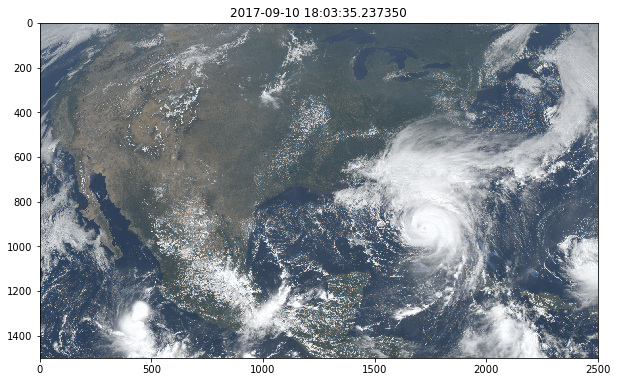

In [93]:
plt.figure(figsize=[10, 8])
plt.imshow(RGB)
plt.title(DATE)

### Plot GOES-16 on a Basemap
The GOES-16 file contains all the metadata needed to understand the map projection of the image. We will use this data to plot the image on a basemap. The data is in a [geostationary projection](http://proj4.org/projections/geos.html).

In [94]:
C.variables['goes_imager_projection']

<type 'netCDF4._netCDF4.Variable'>
int32 goes_imager_projection()
    long_name: GOES-R ABI fixed grid projection
    grid_mapping_name: geostationary
    perspective_point_height: 35786023.0
    semi_major_axis: 6378137.0
    semi_minor_axis: 6356752.31414
    inverse_flattening: 298.2572221
    latitude_of_projection_origin: 0.0
    longitude_of_projection_origin: -89.5
    sweep_angle_axis: x
unlimited dimensions: 
current shape = ()
filling on, default _FillValue of -2147483647 used

Get a few variables needed to create map projection object and create the pyproj object.

In [95]:
# Satellite height
sat_h = C.variables['goes_imager_projection'].perspective_point_height

# Satellite longitude
sat_lon = C.variables['goes_imager_projection'].longitude_of_projection_origin

# Satellite sweep
sat_sweep = C.variables['goes_imager_projection'].sweep_angle_axis

# The projection x and y coordinates equals
# the scanning angle (in radians) multiplied by the satellite height
X = C.variables['x'][:] * sat_h
Y = C.variables['y'][:] * sat_h

# The bounds of the data are also given in the file
north = C.variables['geospatial_lat_lon_extent'].geospatial_northbound_latitude
south = C.variables['geospatial_lat_lon_extent'].geospatial_southbound_latitude
east = C.variables['geospatial_lat_lon_extent'].geospatial_eastbound_longitude
west = C.variables['geospatial_lat_lon_extent'].geospatial_westbound_longitude

# map object with pyproj
p = Proj(proj='geos', h=sat_h, lon_0=sat_lon, sweep=sat_sweep)

With the projection data, we can plot the satellite imagry on a Basemap.

#### Geostationary Basemap

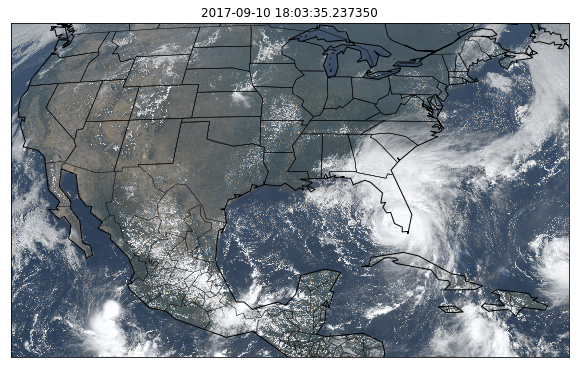

In [96]:
# The geostationary projection is perhaps the easiest way
plt.figure(figsize=[10, 8])
m = Basemap(projection='geos', lon_0='-89.5',
            llcrnrx=X.min(),llcrnry=Y.min(),
            urcrnrx=X.max(),urcrnry=Y.max())
m.imshow(np.flipud(RGB)) # Remember, "images" are upside down, so flip up/down
m.drawcoastlines()
m.drawcountries()
m.drawstates()
plt.title(DATE)

#### Lambert Conformal Projection
This is the same projection as the High Resolution Refresh (HRRR) model. To reproject the data onto this new map, we need to get the latitude and longitude of every point in the data. We can do this by using an inverse transformation of the map projection object and the map coordinates given by X and Y

In [97]:
# Convert map points to latitude and longitude
XX, YY = np.meshgrid(X, Y)
lons, lats = p(XX, YY, inverse=True)

In [98]:
# Make a new map object for the HRRR model domain map projection
mH = Basemap(resolution='i', projection='lcc', area_thresh=1500, \
            width=1800*3000, height=1060*3000, \
            lat_1=38.5, lat_2=38.5, \
            lat_0=38.5, lon_0=-97.5)

xH, yH = mH(lons, lats)

We can't simply plot the reprojected image with imshow because the pixels are irregularly spaced. We have to use pcolormesh, which is slightly tricky. We need to create a color tuple for each pixel. Details on doing this are on stackoverflow [here](https://stackoverflow.com/questions/29232439/plotting-an-irregularly-spaced-rgb-image-in-python) and [here](https://stackoverflow.com/questions/41389335/how-to-plot-geolocated-rgb-data-faster-using-python-basemap). Below is my method.


In [99]:
# Create a color tuple for pcolormesh
rgb = RGB[:,:-1,:] # Useing one less column is very imporant, else your image will be scrambled!
rgb = np.minimum(rgb, 1) # Force the maximum possible RGB value is 1 (the lowest is 0).
colorTuple = rgb.reshape((rgb.shape[0] * rgb.shape[1]), 3)
colorTuple = np.insert(colorTuple, 3, 1.0, axis=1) # adding an alpha channel will plot faster??

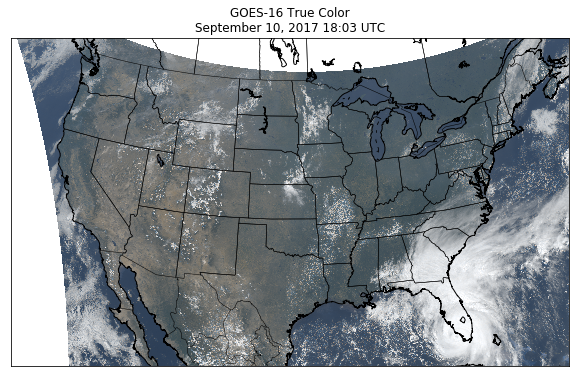

In [100]:
# Now we can plot the GOES data on the HRRR map domain and projection
plt.figure(figsize=[10, 8])
newmap = mH.pcolormesh(xH, yH, R, color=colorTuple, linewidth=0)
newmap.set_array(None) # without this, the linewidth is set to zero, but the RGB color is ignored
mH.drawstates()
mH.drawcountries()
mH.drawcoastlines()

plt.title('GOES-16 True Color\n%s' % DATE.strftime('%B %d, %Y %H:%M UTC'))

Wa-la! You have just projected the GOES-16 data on the HRRR map projection and domain :)

--------

### HRRR Overlay
Ultimately, I wanted to overlay HRRR analyses over the GOES-16 images. I don't show how I got the HRRR data here, but below is a sample image of HRRR simulated reflectivity and 500 mb heights on September 10, 2017 at 1800 UTC.

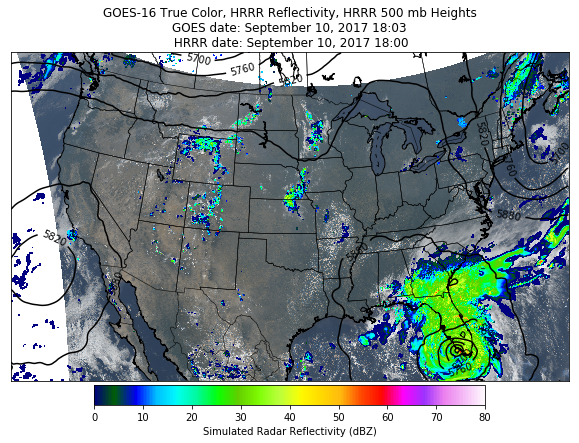

In [101]:
# Load some pre-downloaded HRRR reflectivity data that I have in a numpy dictionary.
H = np.load('HRRR_20170910-1800_REFC.npy').item()

# Load some pre-downloaded HRRR 500 mb heights data that I have in a numpy dictionary.
H500 = np.load('HRRR_20170910-1800_HGT500.npy').item()

# Mask points with no reflectivity
dBZ = H['value']
dBZ = np.ma.array(dBZ)
dBZ[dBZ == -10] = np.ma.masked

plt.figure(figsize=[10,8])
# Plot the GOES image
newmap = mH.pcolormesh(xH, yH, R, color=colorTuple, linewidth=0)
newmap.set_array(None) # without this, the linewidth is set to zero, but the RGB color is ignored

# Plot the HRRR reflectivity
mH.pcolormesh(H['lon'], H['lat'], dBZ, latlon=True, cmap='gist_ncar', vmax=80, vmin=0)
cb = plt.colorbar(orientation='horizontal', shrink=.7, pad=.01)
cb.set_label('Simulated Radar Reflectivity (dBZ)')

# Plot the HRRR 500 mb height
cs = mH.contour(H500['lon'], H500['lat'], H500['value'], latlon=True, colors='k', levels=range(4980, 6100, 60))
plt.clabel(cs, fmt = '%1.0f')

# Plot other map elements
mH.drawstates()
mH.drawcountries()
mH.drawcoastlines()

# Title
date_fmt = '%B %d, %Y %H:%M'
plt.title('GOES-16 True Color, HRRR Reflectivity, HRRR 500 mb Heights\nGOES date: %s\n HRRR date: %s' % (DATE.strftime(date_fmt), H['valid'].strftime(date_fmt)))